In [1]:
import pickle
from aemulusnu_massfunction.emulator_training import *
from aemulusnu_massfunction.fisher_utils import *

fiducial_h = 0.6736
nu_mass_ev = 0.06
# #(Plank 2018 table 2. TT,TE,EE+lowE+lensing  + neutrino mass put in by hand)
# fiducial_cosmology = {'10^9 As':2.1,
#                       'ns': 0.9649,
#                       'H0': 67.36,
#                       'w0': -1,
#                       'ombh2': 0.02237,
#                       'omch2': 0.12,
#                       'nu_mass_ev': nu_mass_ev,}



#(Same as above but put in DES Y3 OmegaM and Sigma8)
print('DES Y3')
Ωmh2 =  0.339*fiducial_h**2 # Y3 3x2pt
Ωνh2 = nu_mass_ev/(93.14) #see astro-ph/0603494
#From the BBN seciton of DES Y3 paper
Ωbh2 = 2.195/100
Ωch2 = Ωmh2-Ωbh2-Ωνh2
fiducial_cosmology = {'10^9 As': 1.520813,  #from σ8 for DES Y3 3x2 and convert_sigma8_to_As.ipynb
                      'ns': 0.9649,
                      'H0': 67.36,
                      'w0': -1,
                      'ombh2': Ωbh2,
                      'omch2': Ωch2,
                      'nu_mass_ev': nu_mass_ev,}

fiducial_cosmo_vals = get_cosmo_vals(fiducial_cosmology)
fiducial_ccl_cosmo = get_ccl_cosmology(tuple(fiducial_cosmo_vals))







z_bin_edges = [0.2, 0.4, 0.6, 0.8, 1.0]
richness_bin_edges = [20., 30., 45., 60., 300.]



print(fiducial_cosmology)


oup_cov_fname = 'tinker08_fiducial_cluster_abundance_covariance_'

for key in fiducial_cosmology:
    ckey = key
    if key == '10^9 As':
        ckey = '1e9As'
    oup_cov_fname += '%s_%f_'%(ckey, fiducial_cosmology[key])

oup_cov_fname = list(oup_cov_fname)

for i,char in enumerate(oup_cov_fname):
    if(char == '.'):
        oup_cov_fname[i] = 'p'

oup_cov_fname = oup_cov_fname[:-1]

oup_cov_fname = ''.join(oup_cov_fname)
oup_cov_fname += '.pkl'

with open(oup_cov_fname, 'rb') as file:
        cluster_count_cov = pickle.load(file)


loading emulator from /home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction/emulator.pkl
DES Y3
{'10^9 As': 1.520813, 'ns': 0.9649, 'H0': 67.36, 'w0': -1, 'ombh2': 0.021949999999999997, 'omch2': 0.13122263790038222, 'nu_mass_ev': 0.06}


In [2]:
z_bin_edges = [0.2, 0.4, 0.6, 0.8, 1.0]
richness_bin_edges = [20., 30., 45., 60., 300.]

n_z = len(z_bin_edges) - 1
n_r = len(richness_bin_edges) - 1
cov_matrix_2d = np.zeros((n_z * n_r, n_z * n_r))

for i in range(n_z):
    for j in range(n_z):
        for a in range(n_r):
            for b in range(n_r):
                row_index = i * n_r + a
                col_index = j * n_r + b
                cov_matrix_2d[row_index, col_index] = cluster_count_cov[i, j, a, b]


In [3]:
cov_inv = np.linalg.inv(cov_matrix_2d)

In [4]:
labels = {
#     '10^9 As': r'10^9A_s',
    'ns': r'n_s',
    'H0': r'H_0',
#     'w0': r'w_0',
    'ombh2': r'\Omega_b h^2',
    'omch2': r'\Omega_c h^2',
    'nu_mass_ev': r'\sum m_\nu',
}

In [5]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 32
plt.rcParams['font.family'] = 'serif'


In [6]:
varied = list(labels.keys())
print(varied)

['ns', 'H0', 'ombh2', 'omch2', 'nu_mass_ev']


In [7]:
import os

dμdθ_step_size = {}
parameter_ranges = {}  # To store the ranges for which files exist

for parameter_changed in tqdm(varied):
    dμdθ_step_size[parameter_changed] = {}
    parameter_ranges[parameter_changed] = {'min': None, 'max': None}
    for log10_rel_step_size in np.arange(-5, 0, .02):
        fname_base = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/cluster_abundance_tinker_fisher_%s_%.4f_nu_mass_ev_%.4f'%(parameter_changed, log10_rel_step_size, fiducial_cosmology['nu_mass_ev'])


        # Check if both files exist
        if os.path.exists(fname_base) and os.path.exists(fname_base + '_neg'):
            with open(fname_base, 'rb') as file:
                cluster_abundance_pos = pickle.load(file)
            with open(fname_base + '_neg', 'rb') as file:
                cluster_abundance_neg = pickle.load(file)

            h = np.abs(fiducial_cosmology[parameter_changed]) * 10**log10_rel_step_size
            tmp_theory_deriv = (cluster_abundance_pos - cluster_abundance_neg) / (2 * h)
            flattened_theory_deriv = np.zeros((n_z * n_r))
            for i in range(n_z):
                for a in range(n_r):
                    flattened_theory_deriv[i * n_r + a] = tmp_theory_deriv[i, a]
            dμdθ_step_size[parameter_changed][np.round(log10_rel_step_size,3)] = flattened_theory_deriv

            # Update the ranges
            if parameter_ranges[parameter_changed]['min'] is None or log10_rel_step_size < parameter_ranges[parameter_changed]['min']:
                parameter_ranges[parameter_changed]['min'] = log10_rel_step_size
            if parameter_ranges[parameter_changed]['max'] is None or log10_rel_step_size > parameter_ranges[parameter_changed]['max']:
                parameter_ranges[parameter_changed]['max'] = log10_rel_step_size



100%|██████████| 5/5 [00:00<00:00, 24.88it/s]


In [8]:
log10_rel_step_sizes = {}

for parameter, ranges in parameter_ranges.items():
#     print(parameter_ranges)
    min_range = round(ranges['min'], 3)
    max_range = round(ranges['max'], 3)
    print(f"For parameter {parameter}, files exist in the range {min_range} to {max_range}.")
    log10_rel_step_sizes[parameter] = np.arange(min_range, max_range, .3)
    if(parameter == 'ns'):
        log10_rel_step_sizes[parameter] = np.arange(min_range, max_range, .2)


For parameter ns, files exist in the range -5.0 to -3.0.
For parameter H0, files exist in the range -3.5 to -1.1.
For parameter ombh2, files exist in the range -3.5 to -1.1.
For parameter omch2, files exist in the range -3.5 to -1.1.
For parameter nu_mass_ev, files exist in the range -3.5 to -1.1.


In [9]:
# log10_rel_step_sizes['nu_mass_ev'] = np.arange(-2.0, -0.3, .025)
# log10_rel_step_sizes['ombh2'] = np.arange(-3.5, -1, .025)

In [10]:
plt.show()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 32
plt.rcParams['font.family'] = 'serif'


In [11]:
print(fiducial_log10_rel_step_size)

{'10^9 As': -2.9, 'ns': -3.6, 'H0': -2.3, 'w0': -2.3, 'ombh2': -2.6, 'omch2': -2.3, 'nu_mass_ev': -1.7}


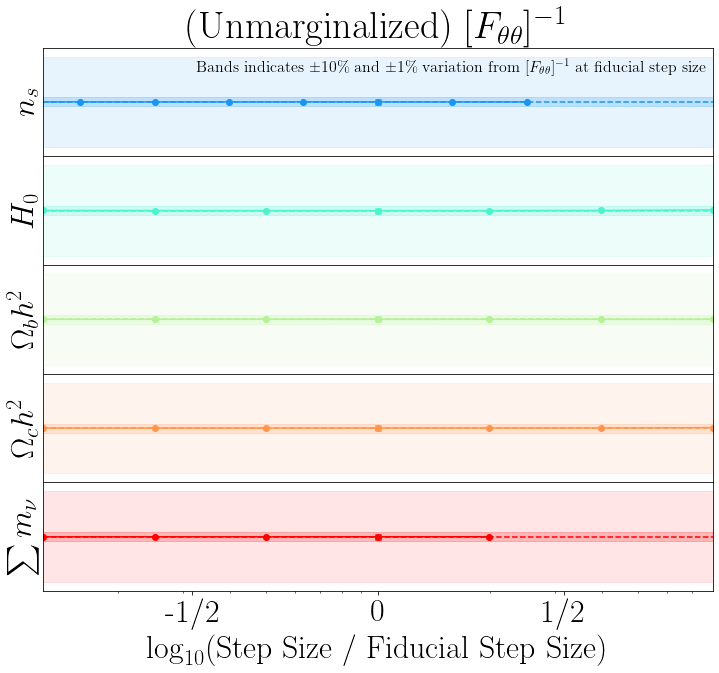

In [12]:
# import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.linalg import cho_solve, cho_factor
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 32
plt.rcParams['font.family'] = 'serif'

# Determine the number of subplots
n_parameters = len(varied)

# Create a figure and an array of subplots with 1 column
fig, axs = plt.subplots(n_parameters, 1, figsize=(12, 2 * n_parameters))#, sharex=True)

# Create a colormap
colormap = cm.rainbow

# Iterate over the parameters and the corresponding axes
for idx, (parameter_changed, ax) in enumerate(zip(varied, axs)):
    Fii_inv = []
    fiducial_value = None
    fiducial_step_size = fiducial_log10_rel_step_size[parameter_changed]
    
    for log10_rel_step_size in log10_rel_step_sizes[parameter_changed]:
        fisher_matrix = np.zeros((n_parameters, n_parameters))
        log10_rel_step_size = np.round(log10_rel_step_size, 3)
        for i, θi in enumerate(varied):
            for j, θj in enumerate(varied):
                dμl_θi = dμdθ_step_size[θi][fiducial_log10_rel_step_size[θi]]
                dμm_θj = dμdθ_step_size[θj][fiducial_log10_rel_step_size[θj]]
                if(θi == parameter_changed): 
#                     print(θi, log10_rel_step_size)
                    dμl_θi = dμdθ_step_size[θi][log10_rel_step_size]
                if(θj == parameter_changed): 
                    dμm_θj = dμdθ_step_size[θj][log10_rel_step_size]
                fisher_matrix[i,j] = np.einsum('l,lm,m', dμl_θi, cov_inv, dμm_θj)

        inv_diagonal_element = fisher_matrix[idx][idx]**(-1)

        Fii_inv += [inv_diagonal_element]
        if np.abs(log10_rel_step_size - fiducial_step_size) < 1e-5:
            fiducial_value = inv_diagonal_element
    if(fiducial_value == None):
        print(parameter_changed)
        continue
            
            
            
            
    # Get a color from the colormap based on the index
    color = colormap((float(idx)+1) / n_parameters)

    X = 10**(log10_rel_step_sizes[parameter_changed])
    X /= 10**fiducial_step_size
    
    ax.plot(X, ((Fii_inv)), color=color)
    ax.scatter(X, ((Fii_inv)), color=color)

    ax.scatter(1, fiducial_value, color=color, marker='x')
    ax.axhline(fiducial_value, color=color, linestyle='--')
    
    fill_x = np.array([10**(-10), 10**10])
    fill_y1 = [0.9 * (fiducial_value), 0.9 * (fiducial_value)]
    fill_y2 = [1.1 * (fiducial_value), 1.1 * (fiducial_value)]
    ax.fill_between(fill_x, fill_y1, fill_y2,  color=color, alpha=0.1)

    fill_y1 = [0.99 * (fiducial_value), 0.99 * (fiducial_value)]
    fill_y2 = [1.01 * (fiducial_value), 1.01 * (fiducial_value)]
    ax.fill_between(fill_x, fill_y1, fill_y2,  color=color, alpha=0.2)

    ax.set_xscale('log')
#     ax.set_xlim(.01,1.99)
    ax.set_xlim(10**(-.9), 10**(.9))
    ax.set_xticks([10**(-.5), 10**0, 10**(.5)])
    ax.set_xticklabels([r'-1/2',r'0',r'1/2' ])

    ax.set_ylim([0.88 * (fiducial_value), 1.12 * (fiducial_value)])

    l = labels[parameter_changed]
    ax.set_yticks([])
    ax.set_ylabel(r'$%s$' % (l))
#     ax.axvline(10**-2)
axs[0].set_title(r'(Unmarginalized) ${[F_{\theta\theta}]^{-1}}$')

s = r'Bands indicates ±10\% and ±1\% variation from ${[F_{\theta\theta}]^{-1}}$ at fiducial step size'
axs[0].text(.99, .90,
        s=s,
        transform=axs[0].transAxes,
        horizontalalignment='right',
        verticalalignment='top',
       fontsize=16)

axs[-1].set_xlabel(r'$\log_{10}$(Step Size / Fiducial Step Size)')
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('unmarginalized_convergencee.pdf')

In [13]:
print(fiducial_log10_rel_step_size)

{'10^9 As': -2.9, 'ns': -3.6, 'H0': -2.3, 'w0': -2.3, 'ombh2': -2.6, 'omch2': -2.3, 'nu_mass_ev': -1.7}


In [14]:
fiducial_log10_rel_step_size['nu_mass_ev'] = -2.3

In [15]:
print(varied)

DESI_BAO_BBN_thetas_H0_omch2_ombh2_cov = -1
with open('../DESI-Y1-mnu-chain/DESI_y1_BAO_BBN_thetas_nuCDM_cov.pkl', 'rb') as file:
    DESI_BAO_BBN_thetas_H0_omch2_ombh2_cov = pickle.load(file)
print(DESI_BAO_BBN_thetas_H0_omch2_ombh2_cov.shape)

fisher_DESI_BAO_BBN_thetas = np.linalg.inv(DESI_BAO_BBN_thetas_H0_omch2_ombh2_cov)


fisher_DESI_BAO_BBN_thetas_dict = {}
for i,key1 in enumerate([ 'H0', 'ombh2', 'omch2']):
    fisher_DESI_BAO_BBN_thetas_dict[key1] = {}
    for j, key2 in enumerate([ 'H0', 'ombh2', 'omch2']):
        fisher_DESI_BAO_BBN_thetas_dict[key1][key2] = fisher_DESI_BAO_BBN_thetas[i][j]

['ns', 'H0', 'ombh2', 'omch2', 'nu_mass_ev']
(3, 3)


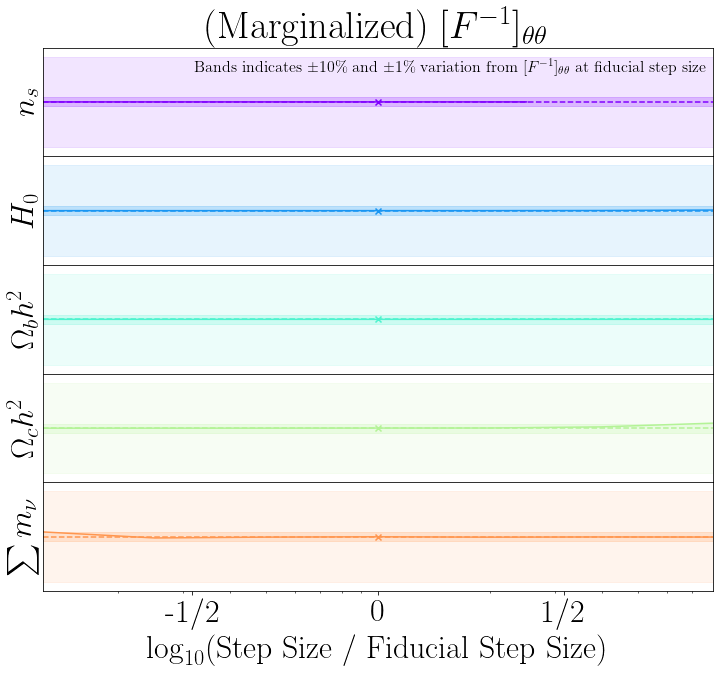

In [16]:
# import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.linalg import cho_solve, cho_factor
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 32
plt.rcParams['font.family'] = 'serif'

# Determine the number of subplots
n_parameters = len(varied)

# Create a figure and an array of subplots with 1 column
fig, axs = plt.subplots(n_parameters, 1, figsize=(12, 2 * n_parameters))#, sharex=True)

# Create a colormap
colormap = cm.rainbow


# adding planck prior 1807.06209 table 2
# TODO, full posterior?
# Planck_σ = {
#     '10^9 As': 0.029,
#     'ns': 0.0038,
#     'H0': 0.42,
#     'w0': np.inf, #unconstrained by main analysis
#     'ombh2':0.00014,
#     'omch2':0.00091,
#     'nu_mass_ev': np.inf, #unconstrained by main analysis
# }


# Iterate over the parameters and the corresponding axes
for idx, (parameter_changed, ax) in enumerate(zip(varied, axs)):
    Fii_inv = []
    fiducial_value = None
    fiducial_step_size = fiducial_log10_rel_step_size[parameter_changed]
    
    for log10_rel_step_size in log10_rel_step_sizes[parameter_changed]:
        fisher_matrix = np.zeros((n_parameters, n_parameters))
        log10_rel_step_size = np.round(log10_rel_step_size, 3)
        for i, θi in enumerate(varied):
            for j, θj in enumerate(varied):
                dμl_θi = dμdθ_step_size[θi][fiducial_log10_rel_step_size[θi]]
                dμm_θj = dμdθ_step_size[θj][fiducial_log10_rel_step_size[θj]]
                if(θi == parameter_changed): 
#                     print(θi, log10_rel_step_size)
                    dμl_θi = dμdθ_step_size[θi][log10_rel_step_size]
                if(θj == parameter_changed): 
#                     print(θj, log10_rel_step_size)
                    dμm_θj = dμdθ_step_size[θj][log10_rel_step_size]
                fisher_matrix[i,j] = np.einsum('l,lm,m', dμl_θi, cov_inv, dμm_θj)
#             fisher_matrix[i,i] += 1/Planck_σ[θi]**2
                if(θi in fisher_DESI_BAO_BBN_thetas_dict and θj in fisher_DESI_BAO_BBN_thetas_dict[θi]):
                    fisher_matrix[i,j] += fisher_DESI_BAO_BBN_thetas_dict[θi][θj]

        # Compute the Cholesky decomposition
        cholesky_factor = cho_factor(fisher_matrix)

        # Solve for the inverse of the diagonal element
        e_i = np.zeros_like(fisher_matrix[idx])
        e_i[idx] = 1
        inv_diagonal_element = cho_solve(cholesky_factor, e_i)[idx]

        Fii_inv += [inv_diagonal_element]
        if np.abs(log10_rel_step_size - fiducial_step_size) < 1.1e-1:
            fiducial_value = inv_diagonal_element

            
            
            
            
    # Get a color from the colormap based on the index
    color = colormap(float(idx) / n_parameters)

    X = 10**(log10_rel_step_sizes[parameter_changed])
    X /= 10**fiducial_step_size
    
    ax.plot(X, ((Fii_inv)), color=color)
#     ax.scatter(X, ((Fii_inv)), color=color)

    ax.scatter(1, fiducial_value, color=color, marker='x')
    ax.axhline(fiducial_value, color=color, linestyle='--')
    
    fill_x = np.array([10**(-10), 10**10])
    fill_y1 = [0.9 * (fiducial_value), 0.9 * (fiducial_value)]
    fill_y2 = [1.1 * (fiducial_value), 1.1 * (fiducial_value)]
    ax.fill_between(fill_x, fill_y1, fill_y2,  color=color, alpha=0.1)

    fill_y1 = [0.99 * (fiducial_value), 0.99 * (fiducial_value)]
    fill_y2 = [1.01 * (fiducial_value), 1.01 * (fiducial_value)]
    ax.fill_between(fill_x, fill_y1, fill_y2,  color=color, alpha=0.2)

    ax.set_xscale('log')
#     ax.set_xlim(.01,1.99)
    ax.set_xlim(10**(-.9), 10**(.9))
    ax.set_xticks([10**(-.5), 10**0, 10**(.5)])
    ax.set_xticklabels([r'-1/2',r'0',r'1/2' ])

    ax.set_ylim([0.88 * (fiducial_value), 1.12 * (fiducial_value)])

    l = labels[parameter_changed]
    ax.set_yticks([])
    ax.set_ylabel(r'$%s$' % (l))
#     ax.axvline(10**-2)
axs[0].set_title(r'(Marginalized) ${[F^{-1}]_{\theta\theta}}$')

s = r'Bands indicates ±10\% and ±1\% variation from ${[F^{-1}]_{\theta\theta}}$ at fiducial step size'
axs[0].text(.99, .90,
        s=s,
        transform=axs[0].transAxes,
        horizontalalignment='right',
        verticalalignment='top',
       fontsize=16)

axs[-1].set_xlabel(r'$\log_{10}$(Step Size / Fiducial Step Size)')
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('marginalized_convergencee_planck_cosmology.pdf', bbox_inches='tight')
plt.savefig('marginalized_convergencee_desY3_cosmology.pdf', bbox_inches='tight')